# 01 — Chokepoint AIS Data Analysis

Objective:
This notebook builds the geospatial and traffic foundation for the Vulnerability Index framework.
It focuses on extracting, cleaning, and visualizing maritime chokepoint traffic data from the PortWatch ArcGIS service.

In [2]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import requests
from datetime import datetime
import time

from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import plotnine

plotnine.options.figure_size = (8, 6)

In [ ]:
def get_chokepoints():
    """
    Retrieves chokepoint metadata from the PortWatch ArcGIS service.
    """
    chokepoints_url = "https://services9.arcgis.com/weJ1QsnbMYJlCHdG/arcgis/rest/services/PortWatch_chokepoints_database/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
    try:
        res = requests.get(chokepoints_url)
        res.raise_for_status()
        # Extracts the 'attributes' dictionary from each feature
        df_chokepoints = pd.DataFrame([feature["attributes"] for feature in res.json()["features"]])
        return df_chokepoints
    except requests.exceptions.RequestException as e:
        print(f"Error fetching chokepoint data: {e}")
        return pd.DataFrame()

# Fetch the chokepoint data
chokepoints_df = get_chokepoints()
print("Successfully fetched chokepoint definitions.")
chokepoints_df.head()

Successfully fetched chokepoint definitions.


,portid,portname,country,ISO3,continent,fullname,lat,lon,vessel_count_total,vessel_count_container,...,vessel_count_tanker,industry_top1,industry_top2,industry_top3,share_country_maritime_import,share_country_maritime_export,LOCODE,pageid,countrynoaccents,ObjectId
0,chokepoint1,Suez Canal,None,None,None,Suez Canal,30.593346,32.436882,20659,5847,...,6584,Mineral Products,Vegetable Products,Chemical & Allied Industries,None,None,None,c57c79bf612b4372b08a9c6ea9c97ef0,None,1
1,chokepoint2,Panama Canal,None,None,None,Panama Canal,9.120512,-79.767238,10968,2678,...,4470,Mineral Products,Vegetable Products,Chemical & Allied Industries,None,None,None,44d73fd00bbc4f73a16d46d5beb11b4d,None,2
2,chokepoint3,Bosporus Strait,None,None,None,Bosporus Strait,41.169282,29.091501,35288,2915,...,8522,Mineral Products,Vegetable Products,Chemical & Allied Industries,None,None,None,837f298c756a4efd85e3fabe31e319ac,None,3
3,chokepoint4,Bab el-Mandeb Strait,None,None,None,Bab el-Mandeb Strait,12.788597,43.349545,20407,5483,...,6781,Mineral Products,Chemical & Allied Industries,Vegetable Products,None,None,None,6b1814d64903461b98144a6cc25eb79c,None,4
4,chokepoint5,Malacca Strait,None,None,None,Malacca Strait,1.516955,102.665106,68922,17397,...,26978,Mineral Products,Chemical & Allied Industries,Vegetable Products,None,None,None,5f51a0d85ac44a6bad02561e25899c4a,None,5


In [4]:
areas_of_interest = [
    "Suez Canal",
    "Panama Canal",
    "Bab el-Mandeb Strait",
    "Malacca Strait",
    "Bosporus Strait"
]
# Filter the main dataframe to our AOIs
chokepoints_sel = chokepoints_df[chokepoints_df['portname'].isin(areas_of_interest)].copy()

# Create a geometry column from longitude and latitude
chokepoints_sel['geometry'] = chokepoints_sel.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Convert to a GeoDataFrame
chokepoints_gdf = gpd.GeoDataFrame(chokepoints_sel, geometry='geometry', crs='EPSG:4326')

print("Selected Chokepoints:")
display(chokepoints_gdf[['portid', 'portname', 'lat', 'lon']])

# Create an interactive map to verify locations
print("\nGenerating interactive map of chokepoint locations...")
m = chokepoints_gdf.explore(
    column="portname",
    cmap="Dark2",
    marker_kwds={"radius": 15},
    tiles="Esri Ocean Basemap",
    tooltip="portname",
    popup=True,
    legend=False
)
display(m)

Selected Chokepoints:


,portid,portname,lat,lon
0,chokepoint1,Suez Canal,30.593346,32.436882
1,chokepoint2,Panama Canal,9.120512,-79.767238
2,chokepoint3,Bosporus Strait,41.169282,29.091501
3,chokepoint4,Bab el-Mandeb Strait,12.788597,43.349545
4,chokepoint5,Malacca Strait,1.516955,102.665106



Generating interactive map of chokepoint locations...


In [ ]:
def get_chokepoint_data(chokepoint_ids):
    """
    Downloads daily transit data for a list of chokepoint IDs.
    Handles API pagination to retrieve all records.
    """
    url_base = "https://services9.arcgis.com/weJ1QsnbMYJlCHdG/arcgis/rest/services/Daily_Chokepoints_Data/FeatureServer/0/query"
    
    # Construct the 'where' clause of the query
    where_clause = " OR ".join([f"portid='{pid}'" for pid in chokepoint_ids])
    
    offset = 0
    all_features = []

    while True:
        params = {
            'where': where_clause,
            'outFields': '*',
            'outSR': '4326',
            'f': 'json',
            'resultOffset': offset
        }
        
        try:
            res = requests.get(url_base, params=params)
            res.raise_for_status()
            features = res.json().get("features", [])
            
            if not features:
                break
            
            all_features.extend(features)
            offset += len(features)
            print(f"\rRetrieved {offset} records...", end="")

        except requests.exceptions.RequestException as e:
            print(f"\nAn error occurred: {e}")
            break
            
    if not all_features:
        print("\nNo data retrieved.")
        return pd.DataFrame()

    print("\nDownload complete. Processing data.")
    df = pd.DataFrame([d["attributes"] for d in all_features])
    
    # Convert timestamp to datetime
    df["date"] = df["date"].apply(lambda x: datetime.fromtimestamp(x / 1000))
    df.sort_values(["portid", "date"], inplace=True)
    df.reset_index(inplace=True, drop=True)
    
    return df

# Get the list of IDs for our selected chokepoints
chokepoint_ids = list(chokepoints_gdf.portid)

# Download the data
daily_data_df = get_chokepoint_data(chokepoint_ids)

daily_data_df.head()

Retrieved 12385 records...
Download complete. Processing data.


,date,year,month,day,portid,portname,n_container,n_dry_bulk,n_general_cargo,n_roro,...,n_cargo,n_total,capacity_container,capacity_dry_bulk,capacity_general_cargo,capacity_roro,capacity_tanker,capacity_cargo,capacity,ObjectId
0,2019-01-01 05:30:00,2019,1,1,chokepoint1,Suez Canal,15,15,7,4,...,41,59,1.018467e+06,618654.148275,111545.251379,21900.777969,1.279776e+06,1.770567e+06,3.050343e+06,1
1,2019-01-02 05:30:00,2019,1,2,chokepoint1,Suez Canal,24,4,5,6,...,39,49,1.534925e+06,227315.781348,8288.383918,37934.294645,5.183062e+05,1.808463e+06,2.326769e+06,2
2,2019-01-03 05:30:00,2019,1,3,chokepoint1,Suez Canal,13,14,9,2,...,38,61,5.550970e+05,977689.832893,39398.170562,10829.719197,8.042576e+05,1.583015e+06,2.387272e+06,3
3,2019-01-04 05:30:00,2019,1,4,chokepoint1,Suez Canal,17,11,2,2,...,32,46,1.044185e+06,430139.704884,3673.345110,3430.301298,7.593845e+05,1.481428e+06,2.240813e+06,4
4,2019-01-05 05:30:00,2019,1,5,chokepoint1,Suez Canal,20,9,1,1,...,31,44,1.218925e+06,777548.144431,4587.562339,5567.023963,6.284811e+05,2.006628e+06,2.635109e+06,5


In [6]:
CANONICAL_MAP = {
    # PortWatch ID -> Canonical Info
    'chokepoint1': {'id': 'cp_suez', 'name': 'Suez Canal'},
    'chokepoint2': {'id': 'cp_panama', 'name': 'Panama Canal'},
    'chokepoint3': {'id': 'cp_bosporus', 'name': 'Bosporus Strait'},
    'chokepoint4': {'id': 'cp_bab_el_mandeb', 'name': 'Bab el-Mandeb Strait'},
    'chokepoint5': {'id': 'cp_malacca', 'name': 'Malacca Strait'},
}

# Apply the mapping to the downloaded data
daily_data_df['chokepoint_id'] = daily_data_df['portid'].map(lambda x: CANONICAL_MAP.get(x, {}).get('id'))
daily_data_df['chokepoint_name'] = daily_data_df['portid'].map(lambda x: CANONICAL_MAP.get(x, {}).get('name'))

# This step now simply ensures data integrity, as the initial filter should have already done the work
daily_data_df_clean = daily_data_df.dropna(subset=['chokepoint_id']).copy()

# Select and reorder final columns for saving
final_traffic_df = daily_data_df_clean[[
    'date',
    'chokepoint_id',
    'chokepoint_name',
    'n_total',
    'n_container',
    'n_dry_bulk',
    'n_general_cargo',
    'n_roro',
    'n_tanker',
    'capacity'
]].sort_values(by=['chokepoint_name', 'date'])

print("Data successfully mapped to canonical IDs.")
display(final_traffic_df['chokepoint_name'].value_counts())

Data successfully mapped to canonical IDs.


chokepoint_name
Bab el-Mandeb Strait    2477
Bosporus Strait         2477
Malacca Strait          2477
Panama Canal            2477
Suez Canal              2477
Name: count, dtype: int64

In [ ]:
chokepoint_metadata = final_traffic_df[['chokepoint_id', 'chokepoint_name']].drop_duplicates()

# We need to add the lat/lon back from our original metadata pull
# First, create a reverse map from canonical_id to the original portid
CANONICAL_MAP_REVERSE = {v['id']: k for k, v in CANONICAL_MAP.items()}
chokepoint_metadata['portid'] = chokepoint_metadata['chokepoint_id'].map(CANONICAL_MAP_REVERSE)

# Merge with the original full metadata df to get the correct lat/lon
chokepoint_metadata = pd.merge(
    chokepoint_metadata,
    chokepoints_df[['portid', 'lat', 'lon']],
    on='portid'
)

output_dir = 'processed_data'
os.makedirs(output_dir, exist_ok=True)
metadata_output_path = os.path.join(output_dir, 'chokepoint_definitions.csv')

chokepoint_metadata[['chokepoint_id', 'chokepoint_name', 'lat', 'lon']].to_csv(metadata_output_path, index=False)

print(f"\chokepoint definitions saved to: {metadata_output_path}")

\chokepoint definitions saved to: processed_data/chokepoint_definitions.csv


In [11]:
output_dir = 'processed_ais_data'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f'chokepoints_daily_data_{time.strftime("%Y_%m_%d")}.csv')
final_traffic_df.to_csv(output_path, index=False)

print(f"\nData saved successfully to: {output_path}")
final_traffic_df.head()


Data saved successfully to: processed_ais_data/chokepoints_daily_data_2025_10_14.csv


,date,chokepoint_id,chokepoint_name,n_total,n_container,n_dry_bulk,n_general_cargo,n_roro,n_tanker,capacity
7431,2019-01-01 05:30:00,cp_bab_el_mandeb,Bab el-Mandeb Strait,50,16,8,4,1,21,2.742136e+06
7432,2019-01-02 05:30:00,cp_bab_el_mandeb,Bab el-Mandeb Strait,59,18,16,6,1,18,2.780443e+06
7433,2019-01-03 05:30:00,cp_bab_el_mandeb,Bab el-Mandeb Strait,58,18,13,5,4,18,2.682136e+06
7434,2019-01-04 05:30:00,cp_bab_el_mandeb,Bab el-Mandeb Strait,47,12,11,3,3,18,2.665114e+06
7435,2019-01-05 05:30:00,cp_bab_el_mandeb,Bab el-Mandeb Strait,74,23,12,11,6,22,3.263790e+06


In [ ]:
df = final_traffic_df[final_traffic_df['date'] >= "2019-01-01"].copy()

print("Original Data Points:", len(df))
print("Date Range:", df['date'].min(), "to", df['date'].max())

# Data Smoothing
# Calculate a 7-day rolling average to reduce daily noise
# We group by 'portname' to calculate the rolling average for each chokepoint independently
rolling_avg_cols = ["n_container", "n_dry_bulk", "n_general_cargo", "n_roro", "n_tanker", "n_total", "capacity"]

print("\nCalculating 7-day rolling averages...")
df_smooth = df.groupby("chokepoint_name")[rolling_avg_cols + ["date"]] \
    .rolling(7, on='date', min_periods=1, center=True) \
    .mean()

# The result of .rolling() has a multi-index, so we reset it to get 'portname' back as a column
df_smooth = df_smooth.reset_index().drop(columns='level_1')
df_smooth.rename(columns={'date_x': 'date'}, inplace=True) # clean up column name

df_smooth.head()

Original Data Points: 12385
Date Range: 2019-01-01 05:30:00 to 2025-10-12 05:30:00

Calculating 7-day rolling averages...


,chokepoint_name,capacity,n_container,n_dry_bulk,n_general_cargo,n_roro,n_tanker,n_total,date
0,Bab el-Mandeb Strait,2.717457e+06,16.000000,12.000000,4.500000,2.250000,18.750000,53.5,2019-01-01 05:30:00
1,Bab el-Mandeb Strait,2.826724e+06,17.400000,12.000000,5.800000,3.000000,19.400000,57.6,2019-01-02 05:30:00
2,Bab el-Mandeb Strait,2.798589e+06,17.166667,12.000000,5.166667,3.000000,19.166667,56.5,2019-01-03 05:30:00
3,Bab el-Mandeb Strait,2.798369e+06,16.714286,12.857143,5.285714,3.428571,18.714286,57.0,2019-01-04 05:30:00
4,Bab el-Mandeb Strait,2.684677e+06,16.571429,13.571429,5.285714,3.571429,18.000000,57.0,2019-01-05 05:30:00


Displaying historical transit data plot...


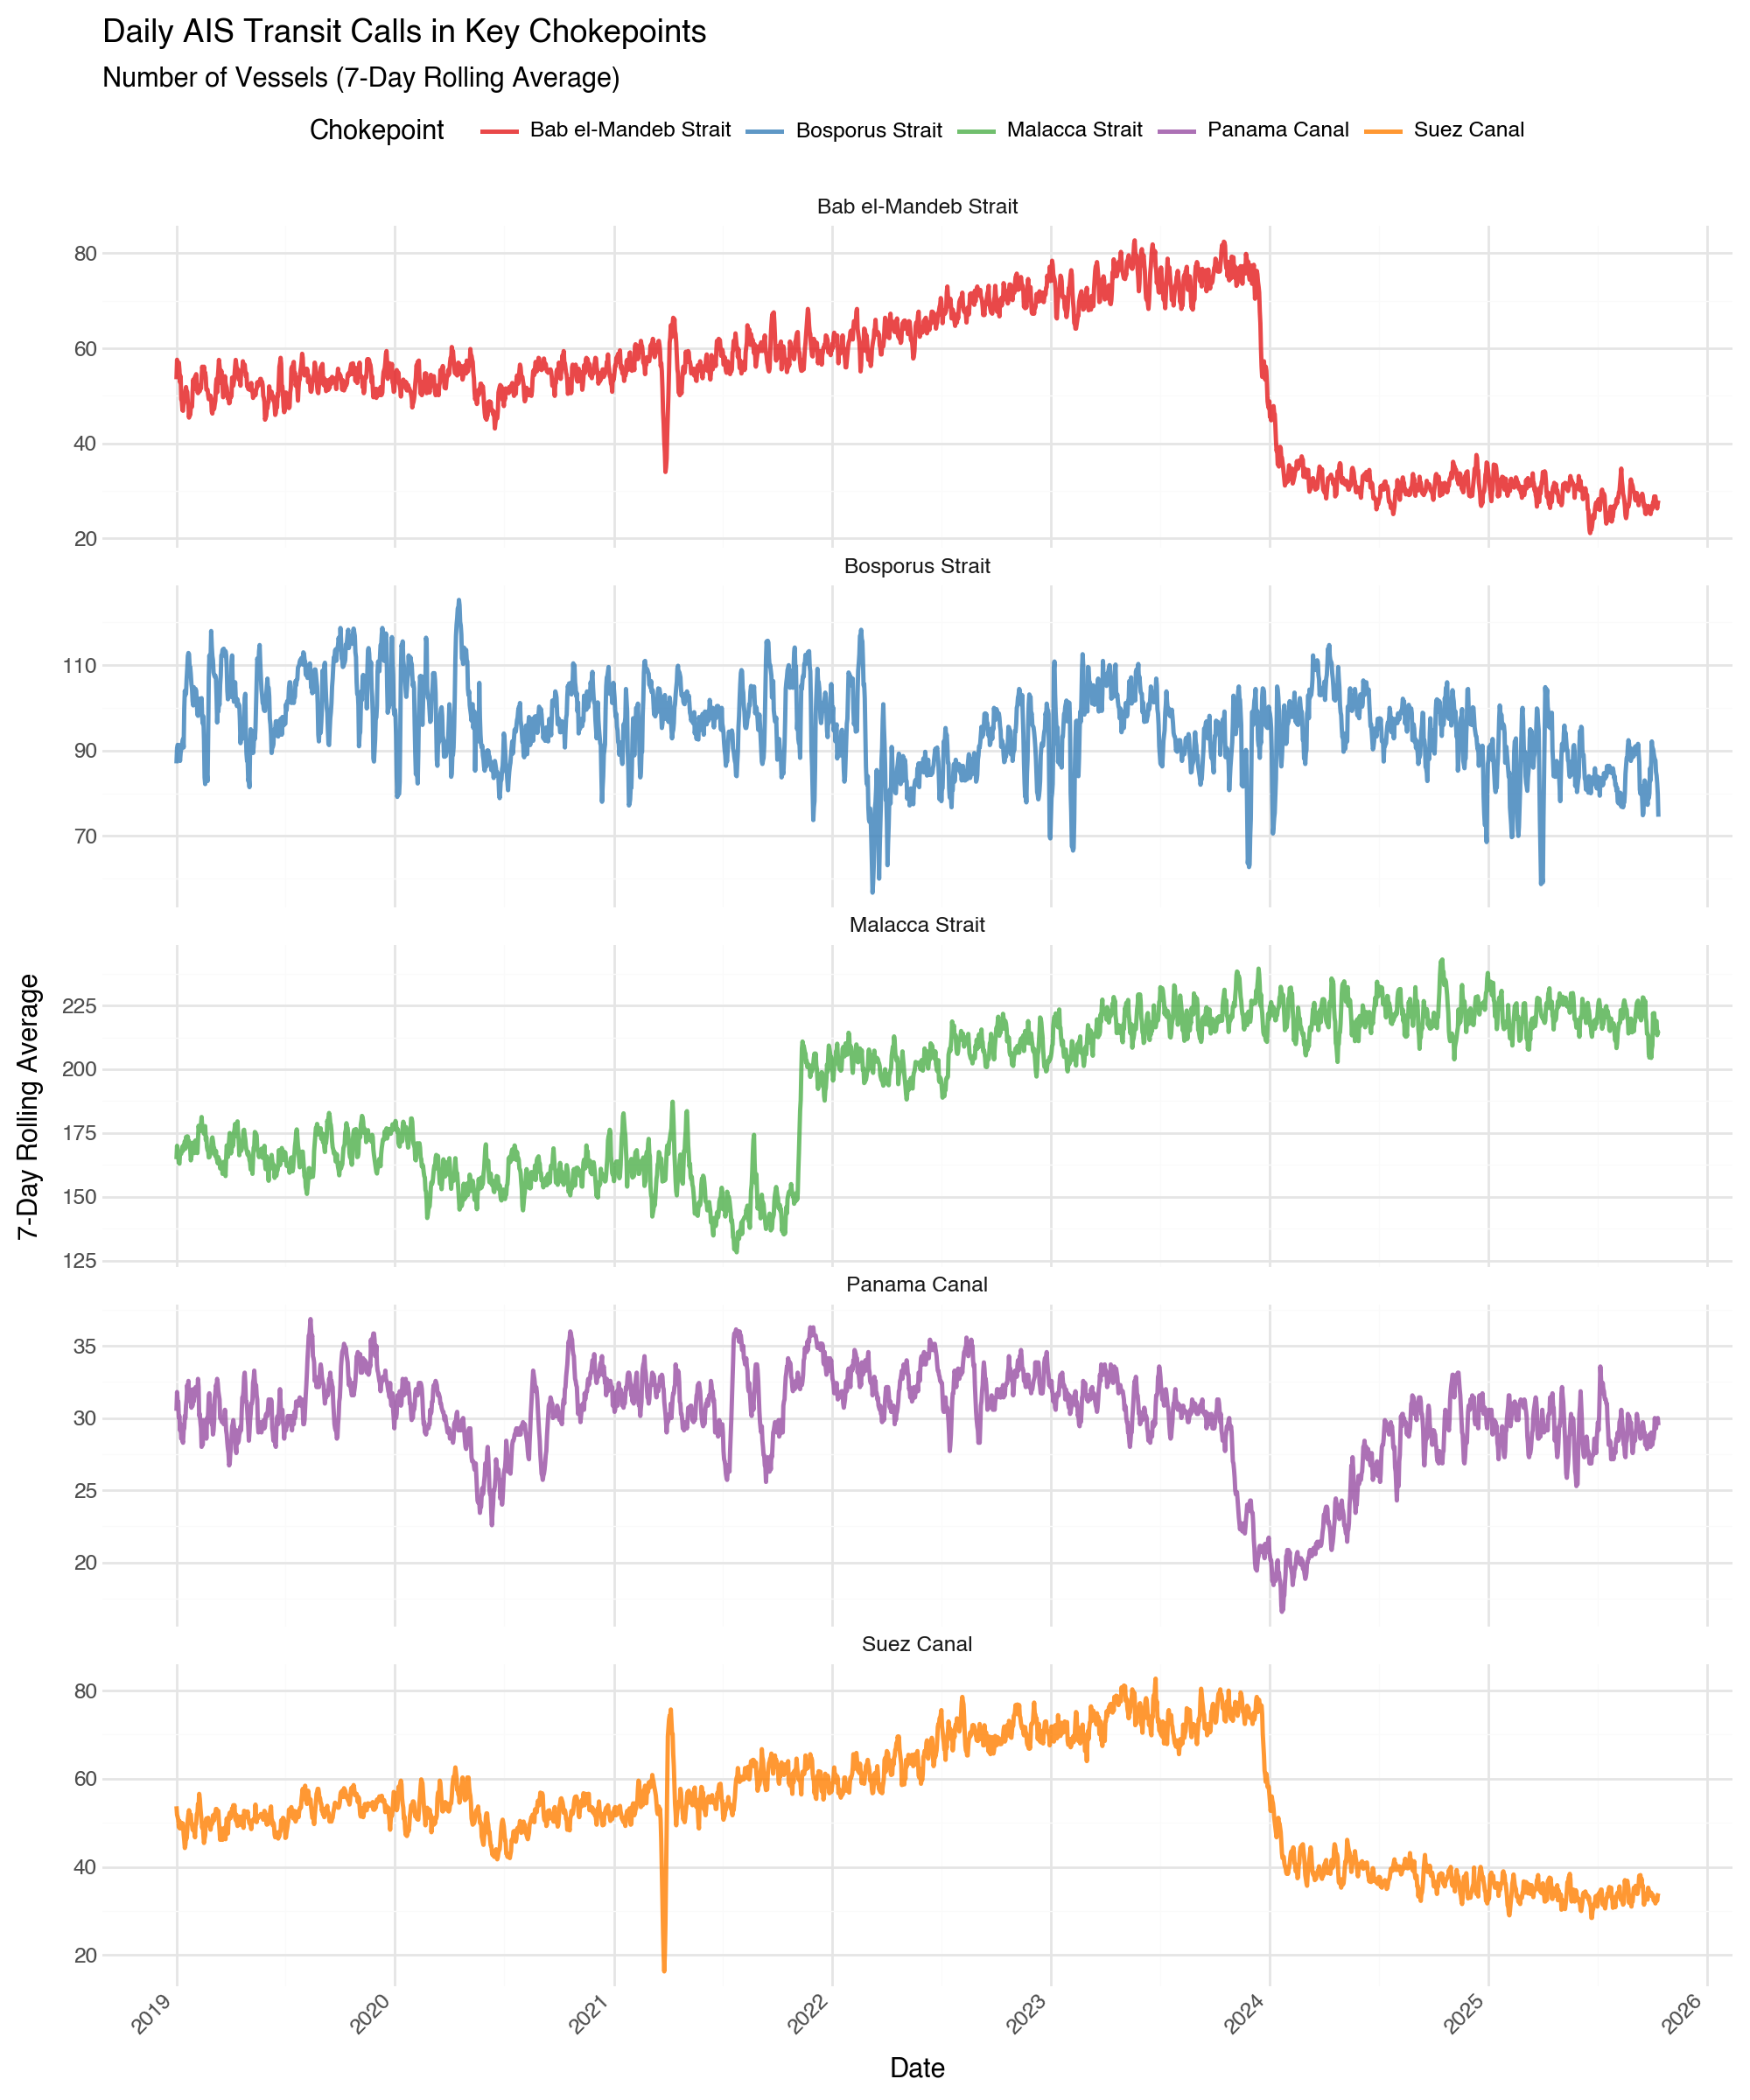

In [ ]:
# Historical plot of total vessel transits
df_smooth['date'] = pd.to_datetime(df_smooth['date'])
p = (
    ggplot(df_smooth, aes(x="date", y="n_total", color="chokepoint_name"))
    + geom_line(alpha=0.8, size=1)
    + labs(
        x="Date",
        y="7-Day Rolling Average",
        subtitle="Number of Vessels (7-Day Rolling Average)",
        title="Daily AIS Transit Calls in Key Chokepoints",
        color="Chokepoint"
    )
    + theme_minimal()
    + scale_x_datetime(date_breaks="1 year", date_labels="%Y")
    + scale_color_brewer(type="qual", palette="Set1")
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="top",
        figure_size=(10, 12) 
    )
    + facet_wrap("~chokepoint_name", scales="free_y", ncol=1)
)

print("Displaying historical transit data plot...")
display(p)

--- Comparing Average Daily Traffic Volume ---
This plot shows the average number of vessels passing through each chokepoint per day.


/var/folders/sw/jvm_9vs95tj9mj54z576clt40000gn/T/ipykernel_3785/1100510275.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



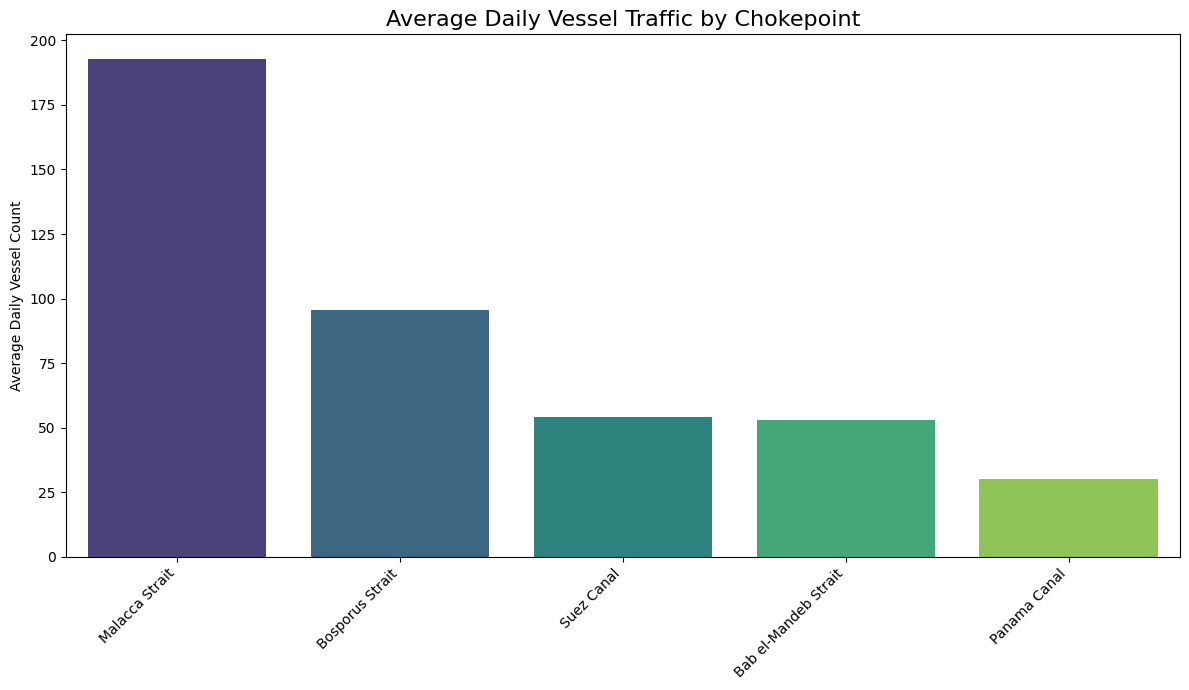

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Comparing Average Daily Traffic Volume ---")
print("This plot shows the average number of vessels passing through each chokepoint per day.")

# Calculate the average n_total for each chokepoint
avg_traffic = final_traffic_df.groupby('chokepoint_name')['n_total'].mean().sort_values(ascending=False).reset_index()

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(
    data=avg_traffic,
    x='chokepoint_name',
    y='n_total',
    palette='viridis'
)

plt.title('Average Daily Vessel Traffic by Chokepoint', fontsize=16)
plt.ylabel('Average Daily Vessel Count')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


--- Vessel Traffic Composition by Chokepoint ---
This plot shows the percentage breakdown of vessel types for each location.


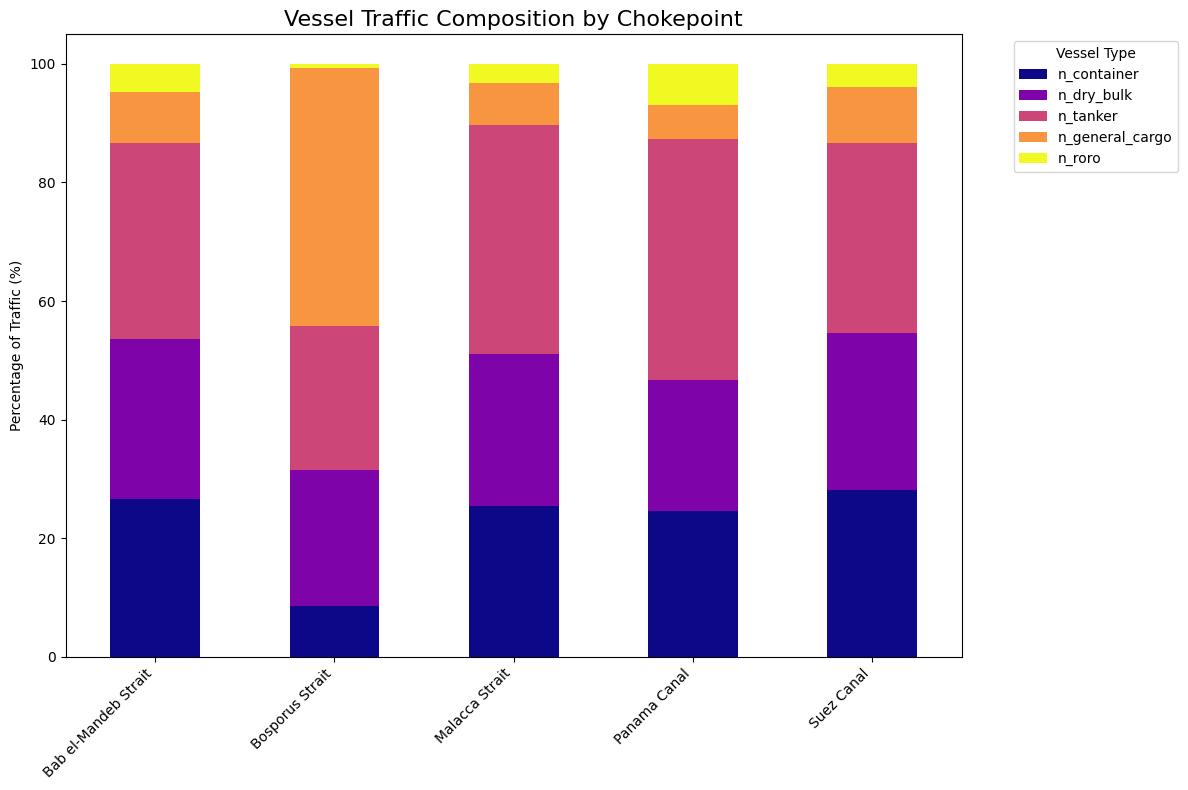

In [ ]:
print("\n--- Vessel Traffic Composition by Chokepoint ---")
print("This plot shows the percentage breakdown of vessel types for each location.")

# Define vessel type columns
vessel_types = ['n_container', 'n_dry_bulk', 'n_tanker', 'n_general_cargo', 'n_roro']

# Calculate the mean of each vessel type for each chokepoint
composition_df = final_traffic_df.groupby('chokepoint_name')[vessel_types].mean()

# Calculate the percentage of each type
composition_pct_df = composition_df.div(composition_df.sum(axis=1), axis=0) * 100

# Plotting the stacked bar chart
ax = composition_pct_df.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 8), 
    colormap='plasma'
)

plt.title('Vessel Traffic Composition by Chokepoint', fontsize=16)
plt.ylabel('Percentage of Traffic (%)')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Vessel Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


--- Weekly Traffic Patterns by Chokepoint ---
This plot shows the distribution of daily traffic for each day of the week.


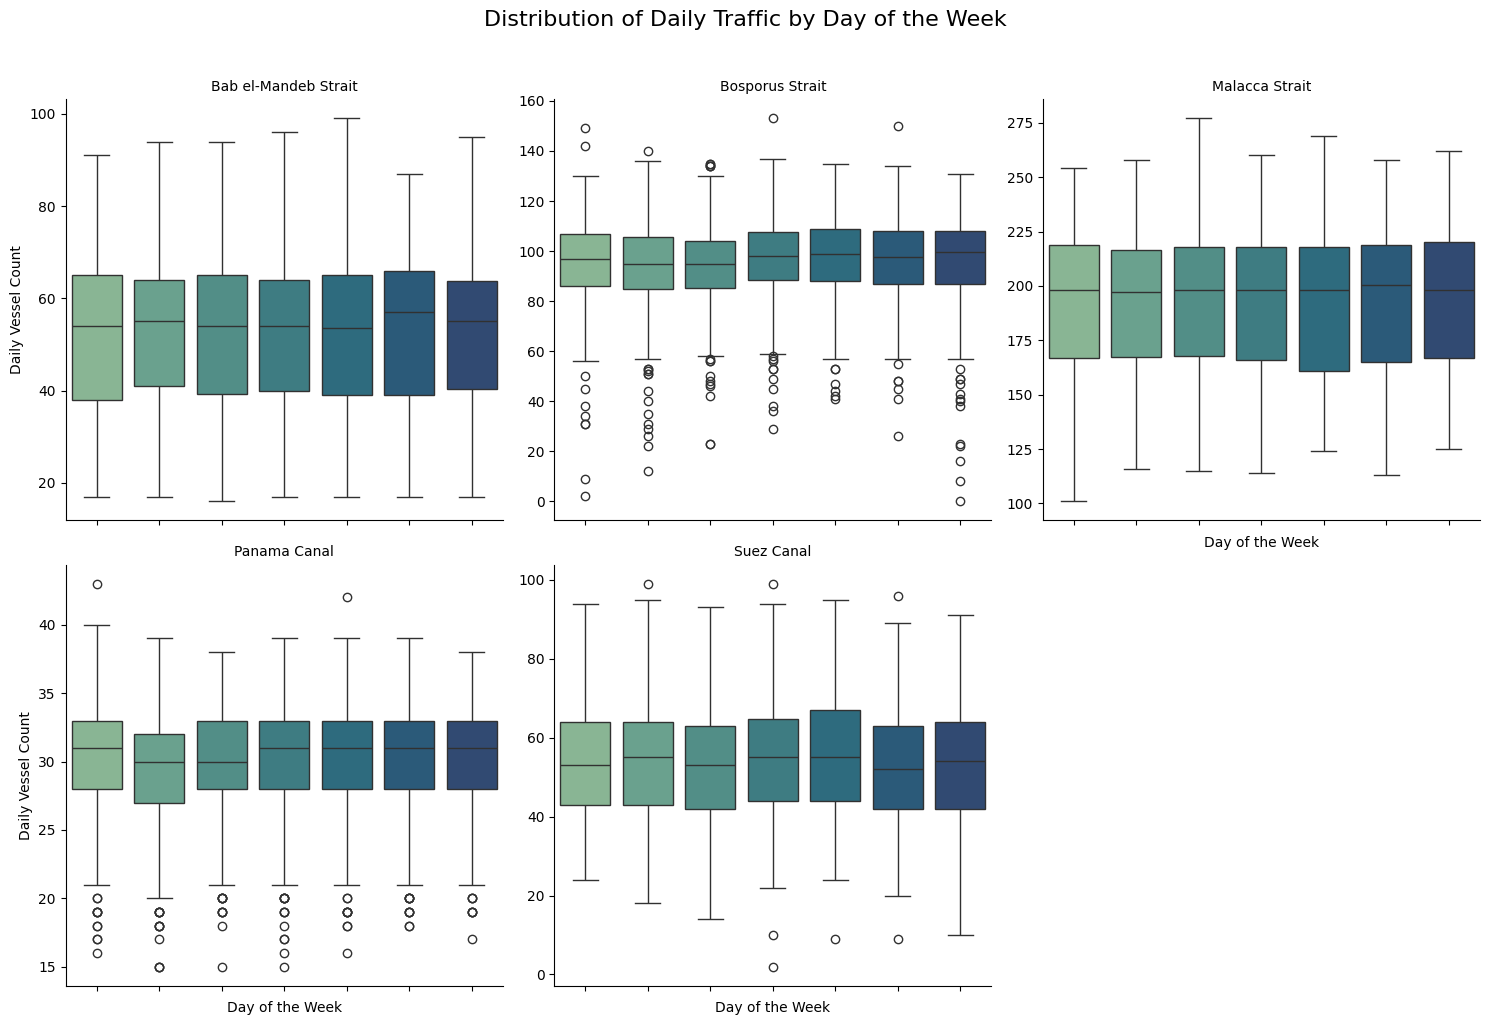

In [19]:
print("\n--- Weekly Traffic Patterns by Chokepoint ---")
print("This plot shows the distribution of daily traffic for each day of the week.")

# Create a 'day_of_week' column (Monday=0, Sunday=6)
df_weekly = final_traffic_df.copy()
df_weekly['day_of_week_num'] = df_weekly['date'].dt.dayofweek
df_weekly['day_of_week_name'] = df_weekly['date'].dt.day_name()

# Order the days correctly for the plot
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Create a FacetGrid to show each chokepoint in its own subplot
g = sns.FacetGrid(df_weekly, col="chokepoint_name", col_wrap=3, height=5, sharey=False)

# Map the boxplot to the grid
g.map(sns.boxplot, "day_of_week_name", "n_total", order=day_order, palette='crest')

g.fig.suptitle('Distribution of Daily Traffic by Day of the Week', y=1.02, fontsize=16)
g.set_titles("{col_name}")
g.set_axis_labels("Day of the Week", "Daily Vessel Count")
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()